Next steps:
- profiling and optimization, parallelize
- save history data and final model
- resume next nw2vec changes + think interactions to explore them

### Imports

In [1]:
include("utils.jl")
include("layers.jl")
using .Utils
using .Layers

using Flux
using LightGraphs
using GraphPlot
using Makie
using Colors
using ProgressMeter
using Statistics
using Distributions
using Random

### Define the graph and features

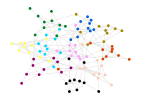

In [2]:
# Parameters
l = 10
k = 10
p_in = 0.4
p_out = 0.01
g = LightGraphs.SimpleGraphs.stochastic_block_model(
    p_in * (k - 1), p_out * k,
    k .* ones(UInt, l), seed = 6
)
communities = [c for c in 1:l for i in 1:k]
labels = Flux.onehotbatch(communities, 1:l)
multin = DiscreteUniform(5, 19)
ufeatures = similar(labels, Float64)
for i in 1:size(ufeatures, 2)
    probs = softmax(convert(Array{Float64}, labels[:, i]))
    ufeatures[:, i] = rand(Multinomial(rand(multin), probs))
end
features = scale_center(ufeatures)

palette = distinguishable_colors(l)
colors = map(i -> getindex(palette, i), communities)
gplot(g, nodefillc = colors)

In [3]:
palette

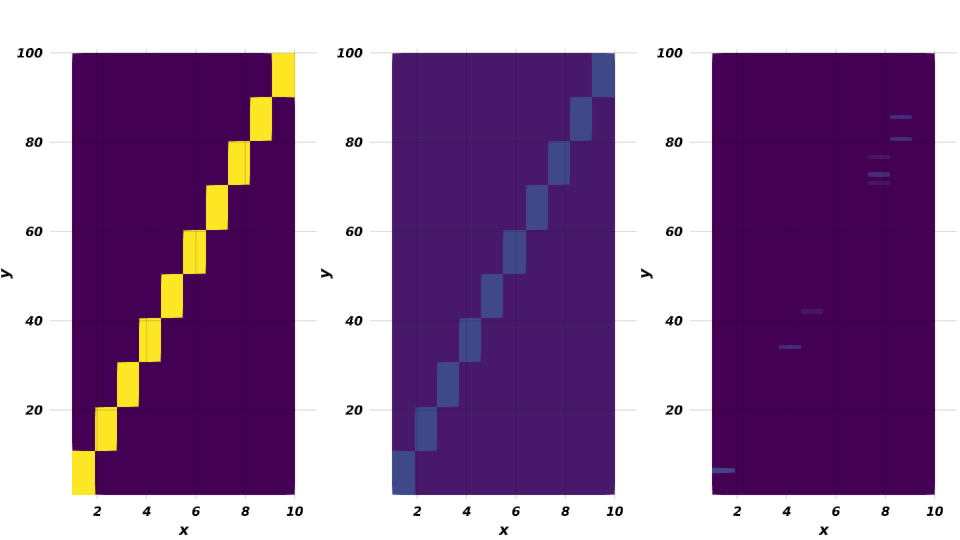

In [4]:
vbox(
    heatmap(1:l, 1:(l*k), labels),
    heatmap(1:l, 1:(l*k), softmax(convert(Array{Float64}, labels)), colorrange = (0, 1)),
    heatmap(1:l, 1:(l*k), ufeatures, colorrange = (5, 19))
)

### Plotting model state

In [5]:
adims(a, dims) = [a[i, :] for i = dims]

function plotstate(;enc, vae, x, refx, g, dims)
    @assert length(dims) in [2, 3]
    embμ, emblogσ = enc(x)
    logitÂ, unormF̂ = vae(x)
    hbox(
        vbox(
            Scene(),
            heatmap(σ.(logitÂ).data, colorrange = (0, 1)),
            heatmap(1:size(x, 1), 1:size(x, 2), softmax(unormF̂).data, colorrange = (0, 1)),
            sizes = [.45, .45, .1]
        ),
        vbox(
            scatter(adims(embμ, dims)..., color = colors, markersize = markersize(embμ)),
            heatmap(Array(adjacency_matrix(g)), colorrange = (0, 1)),
            heatmap(1:size(x, 1), 1:size(x, 2), refx, colorrange = (0, 1)),
            sizes = [.45, .45, .1]
        ),
    )
end

function plotweights(layers...)
    theme = Theme(align = (:left, :bottom), raw = true, camera = campixel!)
    vbox([hbox(heatmap(l.W.data), text(theme, repr(l))) for l in layers]...)
end

plotweights (generic function with 1 method)

### Define the model

In [6]:
dimξadj = 2
dimξfeat = 2
diml1 = Int64(round(sqrt(size(features, 1) * (dimξadj + dimξfeat))))
overlap = 1

# Encoder
l1 = Layers.GC(g, l, diml1, Flux.relu, initb = Layers.nobias)
lμ = Layers.Apply(Layers.VOverlap(overlap),
    Layers.GC(g, diml1, dimξadj, initb = Layers.nobias),
    Layers.GC(g, diml1, dimξfeat, initb = Layers.nobias))
llogσ = Layers.Apply(Layers.VOverlap(overlap),
    Layers.GC(g, diml1, dimξadj, initb = Layers.nobias),
    Layers.GC(g, diml1, dimξfeat, initb = Layers.nobias))
enc(x) = (h = l1(x); (lμ(h), llogσ(h)))

# Sampler
sampleξ(μ, logσ) = μ .+ exp.(logσ) .* randn_like(μ)

# Decoder
decadj = Chain(
    Dense(dimξadj, diml1, Flux.relu, initb = Layers.nobias),
    Layers.Bilin(diml1)
)
decfeat = Chain(
    Dense(dimξfeat, diml1, Flux.relu, initb = Layers.nobias),
    Dense(diml1, l, initb = Layers.nobias),
)
dec(ξ) = (decadj(ξ[1:dimξadj, :]), decfeat(ξ[end-dimξfeat+1:end, :]))

# Final model
vae(x) = dec(sampleξ(enc(x)...))

vae (generic function with 1 method)

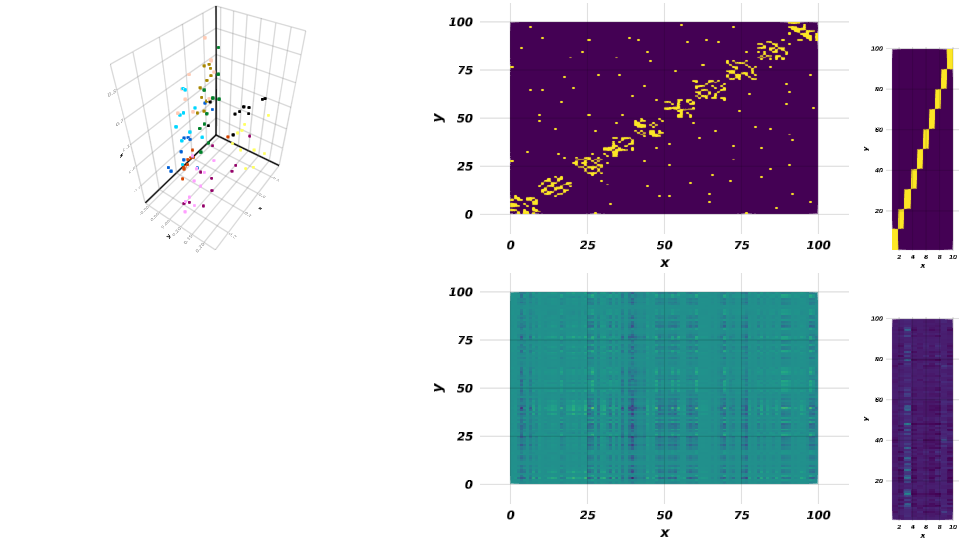

In [7]:
plotstate(enc = enc, vae = vae, x = features, refx = labels, g = g, dims = 1:3)

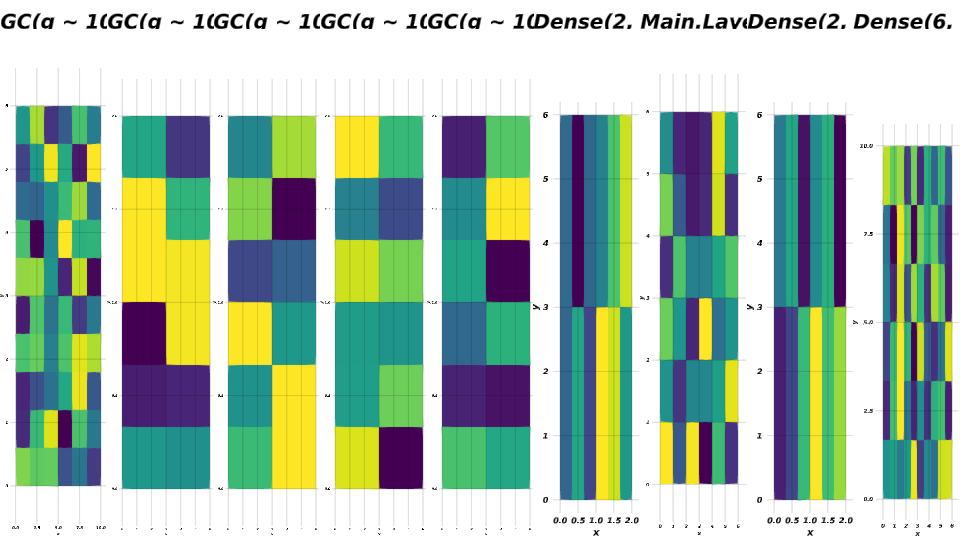

In [8]:
plotweights(l1, lμ.args..., llogσ.args..., decadj.layers..., decfeat.layers...)

### Define losses

In [9]:
Adiag = adjacency_matrix_diag(g)
densityA = mean(adjacency_matrix(g));

In [10]:
# Decoder regularizer
decregularizer(l = 0.01) = l * sum(x -> sum(x.^2), Flux.params(decadj, decfeat))

# Kullback-Leibler divergence
Lkl(μ, logσ) = 0.5 * sum(exp.(2 .* logσ) + μ.^2 .- 1 .- 2 .* logσ)
κkl = size(g, 1) * (dimξadj - overlap + dimξfeat)

# Adjacency loss
Ladj(logitApred) = (
    0.5 * sum(logitbinarycrossentropy.(logitApred, Adiag, pos_weight = (1 / densityA) - 1))
    / (1 - densityA)
)
κadj = size(g, 1)^2 * log(2)

# Features loss
Lfeat(unormfeatpred) = - softmaxcategoricallogprob(unormfeatpred, labels)
κfeat = size(g, 1) * log(size(features, 1))

# Total loss
klscale = 1e-3
regscale = 1e-3
function losses(x)
    μ, logσ = enc(x)
    logitApred, unormfeatpred = dec(sampleξ(μ, logσ))
    Dict("kl" => klscale * Lkl(μ, logσ) / κkl,
        "adj" => Ladj(logitApred) / κadj,
        "feat" => Lfeat(unormfeatpred) / κfeat,
        "reg" => regscale * decregularizer())
end

function loss(x)
    sum(values(losses(x)))
end

loss (generic function with 1 method)

### Train

In [11]:
history = nothing

In [12]:
nepochs = 1000
if isdefined(Main, :history) && history !== nothing
    for (name, values) in history
        history[name] = cat(history[name], zeros(nepochs), dims = 1)
    end
    totalepochs += nepochs
else
    history = Dict(name => zeros(nepochs) for name in keys(losses(features)))
    history["total"] = zeros(nepochs)
    totalepochs = nepochs
end

opt = ADAM(0.01)
@showprogress for i = 1:nepochs
    Flux.train!(loss, Flux.params(l1, lμ, llogσ, decadj, decfeat), [(features,)], opt)

    lossparts = losses(features)
    for (name, value) in lossparts
        history[name][totalepochs-nepochs+i] = value.data
    end
    history["total"][totalepochs-nepochs+i] = sum(values(lossparts)).data
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:22


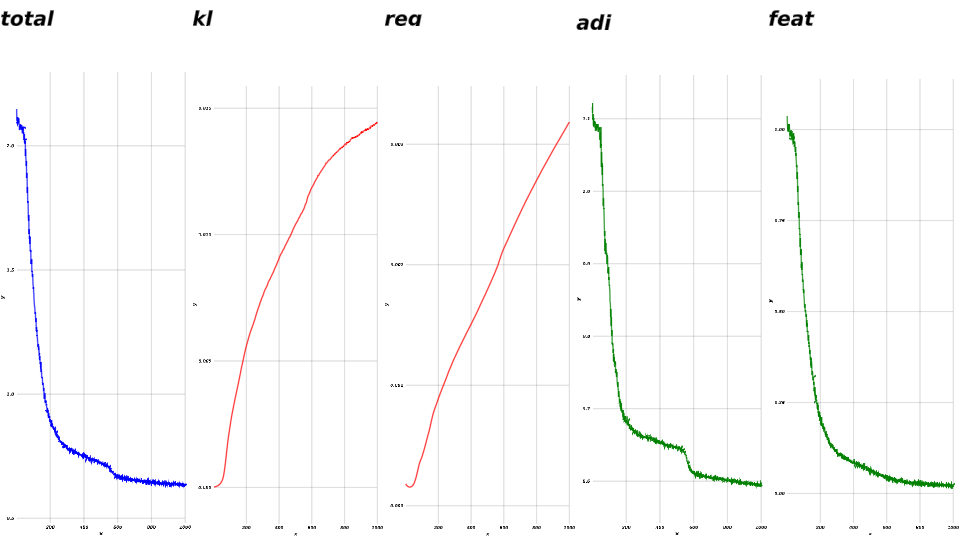

In [13]:
theme = Theme(align = (:left, :bottom), raw = true, camera = campixel!)
vbox([hbox(lines(1:totalepochs, history[name], color = color), text(theme, name))
        for (name, color) in [("total", :blue), ("kl", :red), ("reg", :red), ("adj", :green), ("feat", :green)]]...)

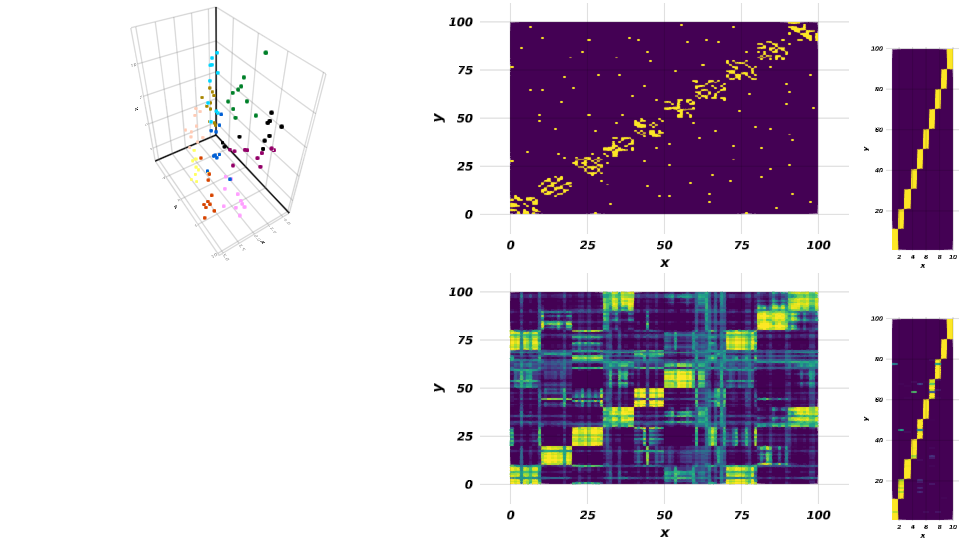

In [14]:
plotstate(enc = enc, vae = vae, x = features, refx = labels, g = g, dims = 1:3)

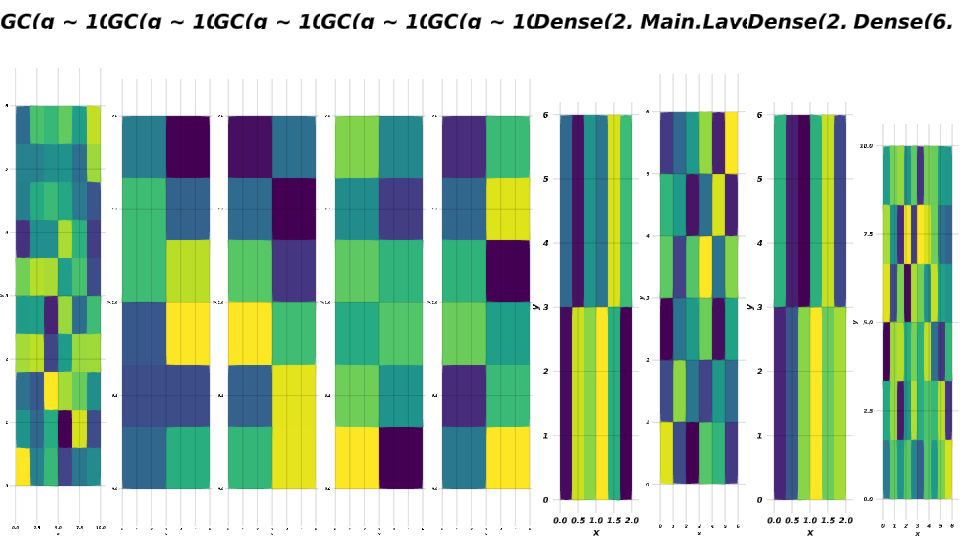

In [15]:
plotweights(l1, lμ.args..., llogσ.args..., decadj.layers..., decfeat.layers...)